Paso 1: Importar las librerías necesarias

In [17]:
y=5

In [31]:
!pip install tensorflow

import tensorflow_datasets as tfds
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
import itertools
import seaborn as sns
import pathlib
import os
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory

import warnings
warnings.filterwarnings('ignore')

Paso 2: Cargar y Preprocesar el Dataset plantae_k

In [2]:
# Cargar el dataset Plantae
# Asegúrate de montar Google Drive si tienes el dataset almacenado allí o de usar la ruta correcta si está en otra ubicación.
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"  # Ejemplo con flores (usa tu propio dataset si tienes uno)
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)

# Crear dataset de entrenamiento y validación
batch_size = 32
img_height = 180
img_width = 180

# Use tf.keras.utils.image_dataset_from_directory instead of just image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Use tf.keras.utils.image_dataset_from_directory instead of just image_dataset_from_directory
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Clases:", class_names)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Clases: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Paso 3: Mostrar algunas imágenes del Dataset

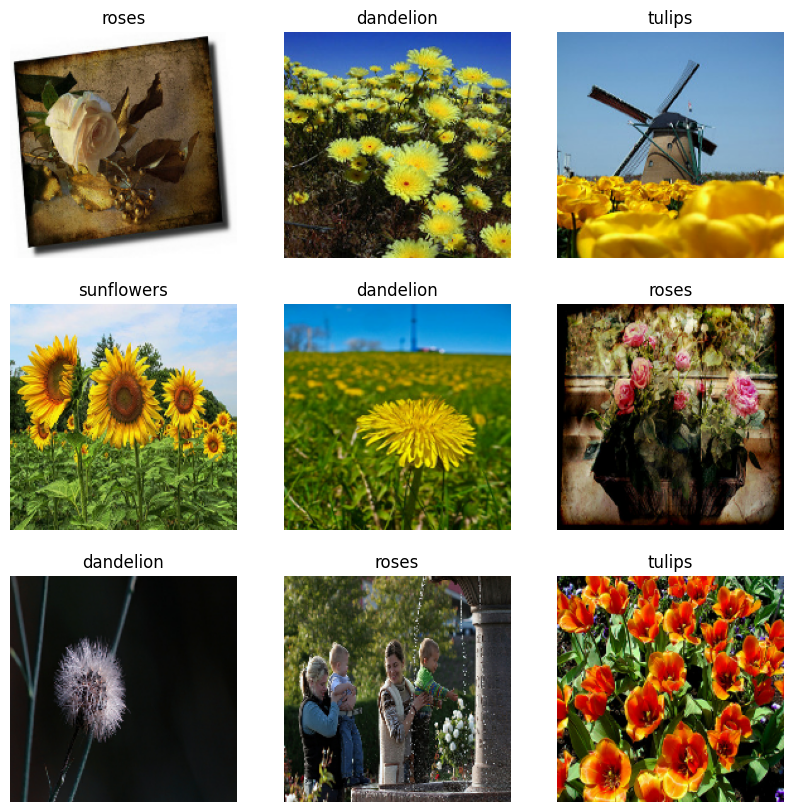

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

Paso 4: # Configurar el dataset para mejorar el rendimiento

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Paso 5: Crear el Modelo de Red Neuronal Convolucional

In [5]:
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    Dropout(rate=0.25), # Changed: Removed layers.add, now directly using Dropout layer
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    Dropout(rate=0.25), # Changed: Removed layers.add, now directly using Dropout layer
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    Dropout(rate=0.25), # Changed: Removed layers.add, now directly using Dropout layer
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    Dropout(rate=0.25), # Changed: Removed layers.add, now directly using Dropout layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(rate=0.25), # Changed: Removed layers.add, now directly using Dropout layer
    layers.Dense(len(class_names), activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Mostrar un resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,327,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,568,709 (5.98 MB)

 Trainable params: 1,568,709 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

Paso 5: Entrenar el Modelo

In [16]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 354s 3s/step - accuracy: 0.2838 - loss: 1.5536 - val_accuracy: 0.4714 - val_loss: 1.2443
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.4849 - loss: 1.1968 - val_accuracy: 0.5381 - val_loss: 1.1638
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.5405 - loss: 1.1013 - val_accuracy: 0.5640 - val_loss: 1.0977
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.5872 - loss: 1.0298 - val_accuracy: 0.6390 - val_loss: 0.9391
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.6415 - loss: 0.9322 - val_accuracy: 0.6403 - val_loss: 0.9241
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.6584 - loss: 0.8896 - val_accuracy: 0.6512 - val_loss: 0.9346
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.6938 - loss: 0.7865 - val_accuracy: 0.6921 - val_loss: 0.8281
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.7398 - loss: 0.6716 - val_accuracy: 0.6839 - v

Paso 6: Guardar el Modelo Entrenado

In [6]:
# Guardar el modelo entrenado
model.save('modelo_plantae_k.keras')



In [10]:
# Load the saved model into the 'loaded_model' variable
loaded_model = keras.models.load_model("modelo_plantae_k.keras")

Paso 7: Evaluar el Modelo y Mostrar Métricas

In [7]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(val_ds)
print(f'Precisión en el conjunto de prueba: {test_acc * 100:.2f}%')

23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 809ms/step - accuracy: 0.2294 - loss: 1.6160
Precisión en el conjunto de prueba: 22.21%


Paso 8: Graficar la Precisión, la Pérdida y Matriz de Confusión

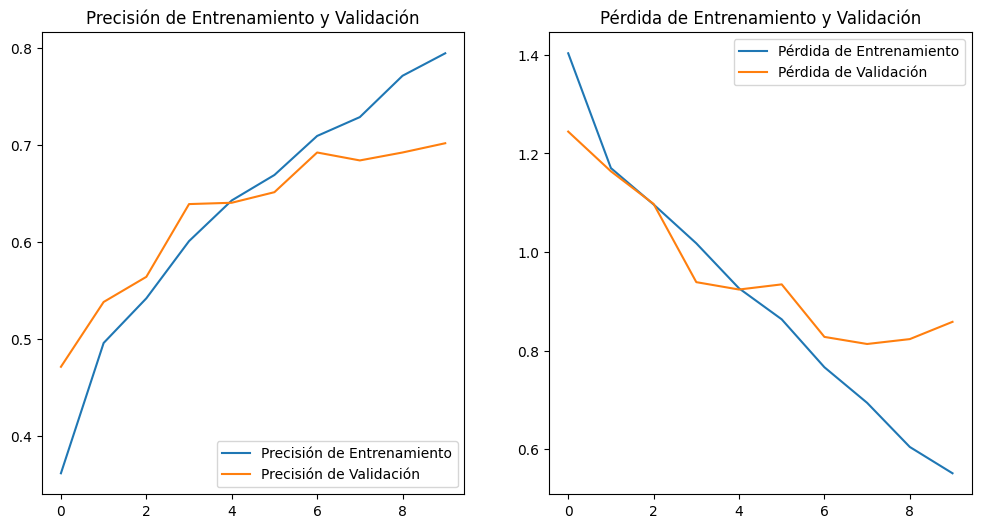

In [19]:
# Gráficos de entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión de Entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión de Validación')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida de Validación')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


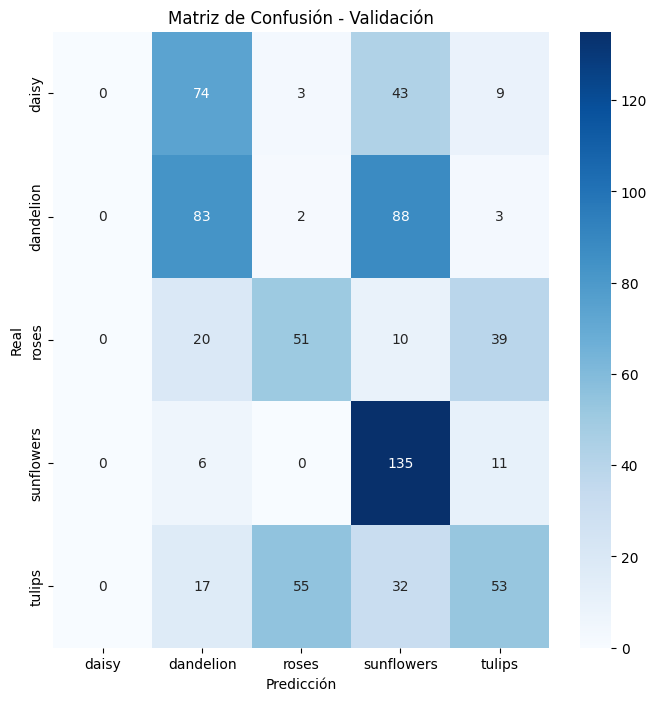

In [12]:
# Evaluar el modelo en el conjunto de validación y mostrar la matriz de confusión
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names) # Now sns is defined and can be used
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Validación')
plt.show()

In [22]:
# Informe de clasificación
print("Reporte de Clasificación:\n", classification_report(y_true, y_pred, target_names=class_names))

Reporte de Clasificación:
               precision    recall  f1-score   support

       daisy       0.20      0.02      0.03       633
   dandelion       0.27      0.57      0.37       898
       roses       0.18      0.47      0.26       641
  sunflowers       0.00      0.00      0.00       699
      tulips       0.17      0.00      0.01       799

    accuracy                           0.23      3670
   macro avg       0.16      0.21      0.13      3670
weighted avg       0.17      0.23      0.14      3670



Paso 9: Hacer Predicciones

In [32]:
# Configuración de los parámetros
img_height = 180
img_width = 180
batch_size = 32

# URL del archivo comprimido
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)


# Cargar el dataset de prueba
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False  # Desactiva el shuffle para mantener el orden
)

class_names = test_ds.class_names
print("Clases:", class_names)

Found 3670 files belonging to 5 classes.
Clases: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [34]:
# Listas para almacenar etiquetas reales y predicciones
y_true = []
y_pred = []

# Realizar predicciones y almacenar resultados
for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())  # Etiquetas verdaderas
    y_pred.extend(np.argmax(predictions, axis=1))  # Etiquetas predichas


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/

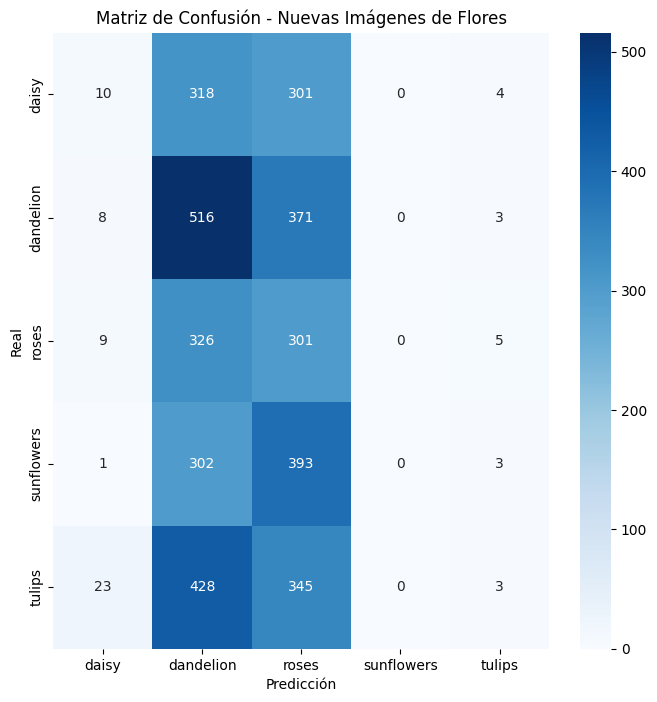

Reporte de Clasificación:
               precision    recall  f1-score   support

       daisy       0.20      0.02      0.03       633
   dandelion       0.27      0.57      0.37       898
       roses       0.18      0.47      0.26       641
  sunflowers       0.00      0.00      0.00       699
      tulips       0.17      0.00      0.01       799

    accuracy                           0.23      3670
   macro avg       0.16      0.21      0.13      3670
weighted avg       0.17      0.23      0.14      3670



In [35]:
# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Nuevas Imágenes de Flores')
plt.show()

# Informe de Clasificación
print("Reporte de Clasificación:\n", classification_report(y_true, y_pred, target_names=class_names))


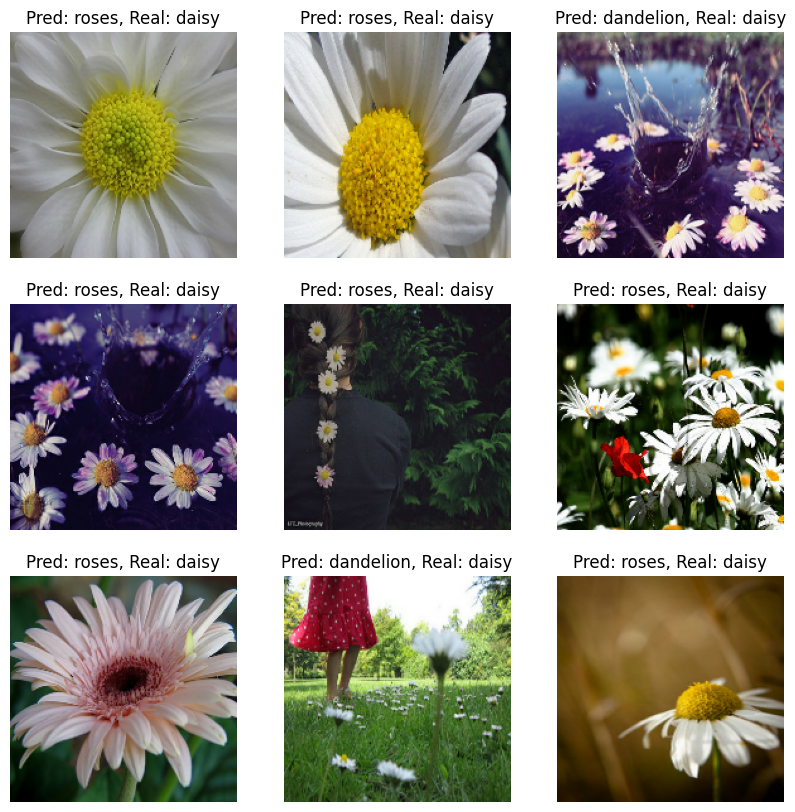

In [36]:
# Mostrar algunas imágenes junto con sus predicciones
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):  # Solo tomamos un batch para mostrar ejemplos
    for i in range(9):  # Mostrar las primeras 9 imágenes
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_label = class_names[y_pred[i]]
        true_label = class_names[labels[i]]
        plt.title(f"Pred: {pred_label}, Real: {true_label}")
        plt.axis("off")
plt.show()
